# Class 7 - Sensitivity testing

In this class, we will integrate a transport model with LCA. More specifically, we will take the output from a Matsim model run, and assess the potential for autonomous electric vehicles to reduce the environmental impact of vehicular traffic.

## Bibliography

### Summary of global and local sensitivity testing:

[Global sensitivity analysis](http://eu.wiley.com/WileyCDA/WileyTitle/productCd-0470059974.html)

### Variance-based global tests:

[Morris method of elementary effects](https://en.wikipedia.org/wiki/Elementary_effects_method)

[Fourier amplitude sensitivity testing](https://en.wikipedia.org/wiki/Fourier_amplitude_sensitivity_testing)

[Variance-based sensitivity analysis](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis)

### Distribution-based global tests:

[A simple and efficient method for global sensitivity analysis based on cumulative distribution functions (PAWN)](http://www.sciencedirect.com/science/article/pii/S1364815215000237)

[Relative entropy based method for probabilistic sensitivity analysis in
engineering design (Entropy)](https://www.researchgate.net/publication/228343915_Relative_Entropy_Based_Method_for_Probabilistic_Sensitivity_Analysis_in_Engineering_Design)

[A new uncertainty importance measure (δ-sensitivity)](http://www.sciencedirect.com/science/article/pii/S0951832006000883)

### Design of experiments

[Design of experiments (Wikipedia)](https://en.wikipedia.org/wiki/Design_of_experiments)

[Design of experiments (NIST Engineering statistics handbook)](http://www.itl.nist.gov/div898/handbook/pri/section1/pri11.htm)

## Installing [SALib](http://salib.readthedocs.org/en/latest/index.html)

1. Open a new terminal window, and activate the `bw2` environment, e.g. by running `C:\bw2-python\bw2-env.bat`.

2. Run the command `pip install --no-cache-dir SALib`.

Before getting started, make sure you have upgrade the Brightway2 packages. You should have at least the following:

In [2]:
try:
    import SALib
except ImportError:
    print("Need to install SALib (https://github.com/SALib/SALib). See section above.")

Need to install SALib (https://github.com/SALib/SALib). See section above.


Now import the necessary libraries:

In [3]:
from brightway2 import *
from bw2data.logs import get_logger
import collections
import csv
import datetime
import itertools
import json
import logging
import numpy as np
import os
import pyprind
import random

Prepare for graphics

In [4]:
%matplotlib inline

In [5]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

sns.set(style="white", palette="muted", color_codes=True)

Can reuse project from Class 5

In [6]:
projects.current = "Class 5"

This class will load and process the input data.

In [7]:
class Data(object):
    def __init__(self, debug=False):
        assert os.path.exists(os.path.join(os.getcwd(), "matsim-files", "person-distances.csv"))
        self.pd = self.get_person_distances()
        self.sd = self.get_station_distances()
        self.rt = self.get_routes()
        self.locations = self.get_locations()
        self.log = get_logger("transport-model", logging.INFO if debug else logging.WARNING)
        if debug:
            print("Writing to log:\n", self.log.handlers[0].baseFilename)
            self.reduce_variables()
    
    def reduce_variables(self):
        included = {'Riniken', 'Remigen', 'Villigen'}
        self.sd = {k: v for k, v in self.sd.items() if k[0] in included and k[1] in included}
        self.rt = [rt for rt in self.rt if rt[2] in included and rt[4] in included]
    
    def get_person_distances(self):
        with open(os.path.join(os.getcwd(), "matsim-files", "person-distances.csv"), 'r') as csvfile:
            data = np.array([float(x[0]) for x in csv.reader(csvfile)])
        return data
    
    def get_station_distances(self):
        with open(os.path.join(os.getcwd(), "matsim-files", "station-distances.csv"), 'r') as csvfile:
            reader = csv.reader(csvfile)
            data = {(x[0], x[1]): float(x[2]) for x in csv.reader(csvfile)}
        return data

    def get_routes(self):
        def translate_time(o):
            h, m, s = [float(x) for x in o.split(":")]
            return round(s / 60 + m + 60 * h)
        
        with open(os.path.join(os.getcwd(), "matsim-files", "routes.csv"), 'r') as csvfile:
            reader = csv.reader(csvfile)
            data = [line for line in reader]
        
        # Add one minute to end time, as car is still in transit in end minute
        return [(translate_time(obj[0]), translate_time(obj[1]) + 1, obj[2], float(obj[3]), obj[4], float(obj[5])) 
                for obj in data]

    def get_locations(self):
        return json.load(open("matsim-files/locations.json"))

In [8]:
data = Data()

The basic model structure is the following:

We have a set of cars in village centers (`Village`). The total numbers of cars is chosen before the model is run; the proportion of cars in each village comes from the number of trips originating in that village.

We have a global timer in our model. Each time the timer clicks forward, for each car (`Car`), one or more of the following happens:

* The car is underway; a certain amount of energy is removed from its batteries (this is done all at once)
* The car is in a charging station; a certain amount of energy is add to its batteries, if necessary
* The car is dispatched to a new route
* The car arrives at a charging station

We will go through the other classes in class :)

In [9]:
class Car(object):
    # Reduce memory usage - we will create thousands of these
    __slots__ = ('id', 'charge', 'capacity', 'consumption', 'charge_rate', 'battery_recovery', 'used')
    
    def __init__(self, i, capacity, consumption, charge_rate):
        self.id = i
        self.capacity = capacity or 15 + 30 * random.random() # kWh
        self.charge = np.ones((24 * 60)) * self.capacity  # Log of battery charge (kWh) over day
        self.battery_recovery = np.zeros(self.charge.shape, dtype=bool)
        self.consumption = consumption # kWh / meter
        self.charge_rate = charge_rate # kWh / minute
        self.used = False
        
    def assign_route(self, route):
        """Deplete battery by distance * self.consumption over route time."""
        self.used = True
        energy_use = route.distance * self.consumption
        assert route.end - route.start
        # Any charging in minute of departure or future is cancelled
        if route.start:
            self.charge[route.start:] = self.charge[route.start - 1]
        self.charge[route.start:route.end] -= np.linspace(0, energy_use, route.end - route.start)
        self.charge[route.end:] = self.charge[route.end - 1]

    def charge_battery(self, time):
        """Add `self.charge_rate` to each minute in the future until fully charged.
        
        Returns whether current battery state is at maximum capacity at `time`."""
        if not self.used or self.charge[time] == self.capacity:
            return True        
        
        if self.charge[time] > self.capacity:
            raise ValueError
        
        minutes_of_full_charge = min(int((self.capacity - self.charge[time]) // self.charge_rate), 24 * 60 - time)
        charging_end = time + minutes_of_full_charge
        self.charge[time:charging_end] += np.arange(1, minutes_of_full_charge + 1) * self.charge_rate
        if charging_end < 24 * 60:
            self.charge[charging_end:] = self.capacity

        if self.charge[time] < 0.25 * self.capacity:
            time_until_80_percent_full = int((self.capacity * 0.8 - self.charge[time]) / self.charge_rate) + 1
            self.battery_recovery[time:time + time_until_80_percent_full] = True

        return self.charge[time] == self.capacity
            
    def __str__(self):
        return "{} car {}".format("Used" if self.used else "Unused", self.id)

In [10]:
Event = collections.namedtuple("Event", ['event', 'kind', 'car', 'location'])

class EventLog(object):
    def __init__(self):
        self.log = [[] for x in range(24 * 60)]
        
    def add_route(self, car, route, rebalance=False):
        self.log[route.start].append(Event(
                event='leave', 
                kind='rebalance' if rebalance else 'route', 
                car=car.id, 
                location=route.from_
            )) 
        data.log.info("Adding event: leave, time: {}, car: {}, from: {}".format(route.start, car.id, route.from_))
        self.log[route.end].append(Event(
                event='arrive', 
                kind='rebalance' if rebalance else 'route', 
                car=car.id, 
                location=route.to
            )) 
        data.log.info("Adding event: arrive, time: {}, car: {}, from: {}".format(route.end, car.id, route.to))

    def arriving(self, time):
        return (x for x in self.log[time] if x.event == 'arrive')

    def __str__(self):
        return "Event log with {} entries".format(len(self.log))

In [11]:
class Unavailable(Exception):
    pass


class Village(object):
    def __init__(self, name, cars, distances):
        self.name = name
        self.cars = cars
        self.neighbors = self.get_neighbors(distances)
        self.log = np.zeros((24 * 60))
                    
    def arrival(self, car, time):
        self.cars.append(car)
        car.charge_battery(time)
        
    def departure(self, car):
        del self.cars[self.cars.index(car)]
        
    def available(self, route, extra_distance):
        try:
            return sorted(
                [car 
                 for car in self.cars 
                 if car.charge[route.start] > (route.distance + extra_distance) * car.consumption
                 and not car.battery_recovery[route.start]], 
                key=lambda x: (x.charge[route.start], x.id),
            )[0]
        except IndexError:
            raise Unavailable
        
    def get_neighbors(self, distances):
        return sorted([(k[1], v) 
                       for k, v in data.sd.items() 
                       if k[0] == self.name 
                       and k[1] != self.name], 
                      key=lambda x: x[1])

    def write_car_log(self, time):
        self.log[time] = len(self.cars)
    
    def __str__(self):
        return "Village: {}".format(self.name)

In [12]:
"""Route runs from route.start to route.end - 1; car is only available the minute *after* the route is finished."""
Route = collections.namedtuple('Route', ['start', 'end', 'from_', 'to', 'distance'])

class AEVModel(object):
    def __init__(self, aev_efficiency_factor=0.15, charge_rate=1/4, 
                 battery_capacity=31.2, num_cars=1e4, avg_speed=500,
                 consumption=0.0002):
        self.aev_efficiency_factor = aev_efficiency_factor
        self.charge_rate = charge_rate            # kWh/minute, from http://www.pluginamerica.org/drivers-seat/understanding-electric-vehicle-charging
        self.battery_capacity = battery_capacity  # kWh - ecoinvent 2.2 default, 312 kg, 100 Wh/kg
        self.num_cars = num_cars                  # Total number of cars to simluate
        self.avg_speed = avg_speed                # meters/minute - 30 km/h
        self.consumption = consumption            # kWh / meter - ecoinvent 2.2 default, 0.2 kWh/km
        self.total_distance = 0
        self.from_neighbors = 0
        
        self.event_log = EventLog()
        self.routes = self.setup_routes(avg_speed)
        self.villages, self.cars = self.setup_transport_system(num_cars)

    def setup_routes(self, avg_speed):
        """Create data structure of (start, end, from_, to, distance) named tuples for routes.
        
        Uses `avg_speed` to translate distances to and from village centres into time."""
        for obj in data.rt:
            assert round(obj[1]) > round(obj[0])
        return [Route(
                    start=round(obj[0] - obj[3] / avg_speed),
                    end=round(obj[1] + obj[5] / avg_speed),
                    from_=obj[2], 
                    to=obj[4], 
                    distance=data.sd[(obj[2], obj[4])] + obj[3] + obj[5]) 
                for obj in data.rt 
                # Must finish before day is over
                if round(obj[1] + obj[5] / avg_speed) <= 24 * 60 - 1]
        
    def setup_transport_system(self, num_cars):
        car_count = itertools.count()
        count = {obj[0]: 0 for obj in data.sd}            
        for route in self.routes:
            count[route.from_] += 1
            count[route.to] -= 0.5  # Penalize for incoming cars

        # print(np.histogram(list(count.values())))

        # At least a weight of 50 in each origin
        for key, value in count.items():
            if value < 150:
                count[key] = 150
            elif value > 500:
                count[key] = 500 # 500 + 0.5 * (value - 500)
        
        total_trips = sum(count.values())
        
        villages = {}
        for name in {obj[0] for obj in data.sd}:
            num_cars = round(count[name] / total_trips * self.num_cars)
            villages[name] = Village(
                name, 
                [Car(next(car_count), self.battery_capacity, self.consumption, self.charge_rate) for x in range(num_cars)],
                data.sd
            )
        
        return villages, {car.id: car for k, v in villages.items() for car in v.cars}
    
    def rebalance_villages(self, time):
        # TODO
        return

    def dispatch_car(self, route):
        village = self.villages[route.from_]
        car = None
        try:
            car = village.available(route, 0)
            if route.end - route.start:
                village.departure(car)
            self.event_log.add_route(car, route)
            car.assign_route(route)
            self.total_distance += route.distance
            return
        except Unavailable:
            pass
        for neighbor, extra_distance in village.neighbors:
            try:
                nv = self.villages[neighbor]
                delay = round(extra_distance / self.avg_speed)
                total_distance = route.distance + extra_distance
                car = nv.available(route, total_distance)
                if route.end + delay >= 24 * 60:
                    # Route can't be finished due to delays, so is dropped
                    return
                route = Route(route.start, route.end + delay, neighbor, route.to, total_distance)
                if route.end - route.start:
                    nv.departure(car)
                car.assign_route(route)
                self.event_log.add_route(car, route)
                self.from_neighbors += 1
                self.total_distance += total_distance
                return
            except Unavailable:
                pass
        raise Unavailable
    
    def iterate(self, time):
        """The fundamental model algorithm."""
        for event in self.event_log.arriving(time):
            self.villages[event.location].arrival(self.cars[event.car], time)
        for rt in (route for route in self.routes if route.start == time):
            self.dispatch_car(rt)
        # self.rebalance_villages(time)
        # for v, k in self.villages.items():
        #    k.charge_cars(time)        
        for village in self.villages.values():
            village.write_car_log(time)        
    
    def execute(self):
        for x in pyprind.prog_bar(range(24*60)):
            self.iterate(x)
        self.wraparound()

    def wraparound(self):
        """Charge the batteries of the cars which aren't full by starting again from time 0"""
        for car in self.cars.values():
            if car.charge[-1] == car.capacity:
                continue
            minutes_needed = int((car.capacity - car.charge[-1]) / car.charge_rate) + 1
            if car.charge[minutes_needed] == car.capacity:
                # Can charge before first use
                car.charge[:minutes_needed] = car.charge[-1] + np.arange(1, minutes_needed + 1) * car.charge_rate 
            else:
                first_use = np.where(car.charge < car.capacity)[0][0]
                car.charge[:first_use] = car.charge[-1] + np.arange(1, first_use + 1) * car.charge_rate 
        
    # Interpretation
    ################
    
    def car_array(self, only_active=False):
        if only_active:
            return np.hstack([car.charge.reshape((-1, 1)) 
                              for car in self.cars.values()
                              if car.used]) 
        else:
            return np.hstack([car.charge.reshape((-1, 1)) for car in self.cars.values()]) 
    
    def statistics(self):
        arr = self.car_array(True)
        total_cars = len(self.cars)
        used = sum(1 for car in self.cars.values() if car.used)
        energy_use = np.diff(arr, axis=0)
        return {
            'cars': total_cars,
            'cars used': used,
            'energy used': energy_use[energy_use < 0].sum(),
            'energy charged': energy_use[energy_use > 0].sum()
        }

    def consumption_array(self):
        arr = base_model.car_array(1)
        energy_use = np.diff(arr, axis=0)
        mask = energy_use < 0
        energy_use[~mask] = 0
        result = np.zeros(arr.shape[0])
        result[1:] = energy_use.sum(axis=1)
        return result
        
    def charging_array(self):
        arr = base_model.car_array(1)
        energy_use = np.diff(arr, axis=0)
        mask = energy_use > 0
        energy_use[~mask] = 0
        result = np.zeros(arr.shape[0])
        result[1:] = energy_use.sum(axis=1)
        return result
    
    def plot_sample_cars(self):
        plt.figure(figsize=(10, 8))

        count = 0

        xs = np.arange(24*60)
        for k, car in self.cars.items():
            if not car.used:
                continue
            else:
                plt.plot(xs, car.charge, alpha=0.2)
                count += 1
            if count > 50:
                break

        plt.xlabel("Time (minutes)")
        plt.xlabel("Time (hours)")
        plt.xticks([120 * x for x in range(13)], range(0, 25, 2))
        plt.xlim(0, 24*60)
        plt.ylabel("Battery storage (kWh)")        
    
    def plot_battery_charge(self, only_active=True):
        plt.figure(figsize=(10, 4))

        count = 0

        xs = np.arange(24*60)
        ys = self.consumption_array()

        plt.plot(xs, ys)

        plt.xlabel("Time (hours)")
        plt.xticks([120 * x for x in range(13)], range(0, 25, 2))
        plt.xlim(0, 24*60)
        plt.ylim(0, plt.ylim()[1] * 1.1)
        plt.ylabel("Total battery charge (kWh)")  
        
    def plot_charging(self):
        plt.figure(figsize=(10, 4))

        count = 0

        xs = np.arange(24*60)
        ys = self.charging_array()

        plt.plot(xs, ys)

        plt.xlabel("Time (hours)")
        plt.xticks([120 * x for x in range(13)], range(0, 25, 2))
        plt.xlim(0, 24*60)
        plt.ylim(0, plt.ylim()[1] * 1.1)
        plt.ylabel("Total charging energy use (kWh)")  
        
    def plot_villages(self):
        directory_path = os.path.join(os.getcwd(), "villages")

        if not os.path.isdir(directory_path):
            os.mkdir(directory_path)

        sns.set_style("white")
        rect_color = sns.color_palette()[1]

        for i in pyprind.prog_bar(range(0, 24 * 60, 1)):
            plt.clf()

            xs, ys, sizes = [], [], []

            for k, v in base_model.villages.items():
                x, y = data.locations[k]
                xs.append(x)
                ys.append(y)
                sizes.append(v.log[i])

            plt.scatter(xs, ys, s=sizes, alpha=0.5, edgecolors="face")

            xlim = plt.xlim()

            ylim = plt.ylim()
            plt.ylim(ylim[0] - 0.1, ylim[1])

            ylim = plt.ylim()

            bottom = ylim[0] + 0.1 * (ylim[1] - ylim[0])
            height = 0.05 * (ylim[1] - ylim[0])

            left = xlim[0] + 0.1 * (xlim[1] - xlim[0])
            width = 0.8 * (xlim[1] - xlim[0]) * (i / 1440)

            ca = plt.gca()
            ca.add_patch(Rectangle((left, bottom), width, height, facecolor=rect_color, edgecolor="none", visible=True, alpha=0.5))
            plt.text(left + width, bottom + height + 0.02, "{:02d}:{:02d}".format(i // 60, i % 60), ha='center', va='center', fontsize=14)

            plt.xticks([])
            plt.yticks([])
            sns.despine(left=True, bottom=True, trim=True)
            
            plt.tight_layout()
            plt.savefig(os.path.join(directory_path, "car_map_{0:04d}.png".format(i)), dpi=300)
            
        sns.set_style("darkgrid")
        
    def save_calliope_charge_array(self):
        arr = self.charging_array()
        np.savetxt("charge.csv", [arr[i * 15:(i * 15) + 1].sum() for i in range(24 * 4)])

# Set up our problem and objective function

We will try to minize the climate change LCA score in this class.

In [13]:
db = Database("ecoinvent 2.2")
electric_car = db.search("transport electric car")[0]
print(electric_car)

subtracted_electricity = list(db.search("operation passenger electric car")[0].technosphere())[0].input
print(subtracted_electricity)

electricity = db.search("electricity, natural gas, at combined cycle plant, best technology")[0]
print(electricity)

gwp =  ('IPCC 2013', 'climate change', 'GWP 100a')

lca = LCA({electric_car: 1}, gwp)
lca.lci()
lca.lcia()
electric_car_impact = lca.score / 1000 # Convert km to m

lca = LCA({subtracted_electricity: 1}, gwp)
lca.lci()
lca.lcia()
subtracted_electricity_impact = lca.score

lca = LCA({electricity: 1}, gwp)
lca.lci()
lca.lcia()
electricity_impact = lca.score

def get_impact(distance, consumption):
    return (distance * electric_car_impact + 
            (electricity_impact - subtracted_electricity_impact) * distance * consumption)

'transport, passenger car, electric, LiMn2O4' (person kilometer, CH, ['transport systems', 'road'])
'electricity, low voltage, consumer mix, at grid' (kilowatt hour, CH, ['electricity', 'supply mix'])
'electricity, natural gas, at combined cycle plant, best technology' (kilowatt hour, RER, ['natural gas', 'power plants'])


In [46]:
initial_values = np.array((1/4, 31.2 * 1.5, 0.0002))

problem = {
    'num_vars': 3,
    'names': ['charge rate', 'battery capacity', 'energy consumption'],
    'groups': None,
    'bounds': [[1/4 - 1/8, 1/4 + 1/8],
               [31.2, 31.2 * 2],
               [0.0001, 0.0003]]
}

In [15]:
def objective_function(input_parameters):
    charge_rate, battery_capacity, consumption = input_parameters
    model = AEVModel(
        num_cars = len(data.rt) / 10, 
        charge_rate=charge_rate, 
        battery_capacity=battery_capacity,
        consumption=consumption
    )
    model.execute()
    return get_impact(model.total_distance, consumption)

In [16]:
objective_function(initial_values)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 33.218 sec


75836.475897054712

# Local sensitivity testing

Vary each parameter independently.

In [16]:
objective_function((1/4 * 0.9, 31.2, 0.0002))

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 22.062 sec


75843.84091030205

In [17]:
objective_function((1/4, 31.2 * 0.9, 0.0002))

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 22.789 sec


75842.58283648797

In [18]:
objective_function((1/4, 31.2, 0.0002 * 0.9))

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 22.698 sec


71875.88078335376

# Global sensitivity testing

## Sampling

In [52]:
from SALib.sample import saltelli as saltelli_sample
from SALib.sample import morris as morris_sample
from SALib.analyze import morris as morris_analyze
from SALib.sample import fast_sampler
from SALib.sample import latin as latin_sampler
from SALib.sample import sobol_sequence
from SALib.analyze import sobol as sobol_analyze

In [45]:
example_problem = {
    'num_vars': 2,
    'names': ['x1', 'x2'],
    'bounds': [[0, 10],
               [0, 10]]
}

In [20]:
def plot_sample(xs, ys):
    plt.figure(figsize=(8,8))
    plt.scatter(xs[:100], ys[:100])
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")

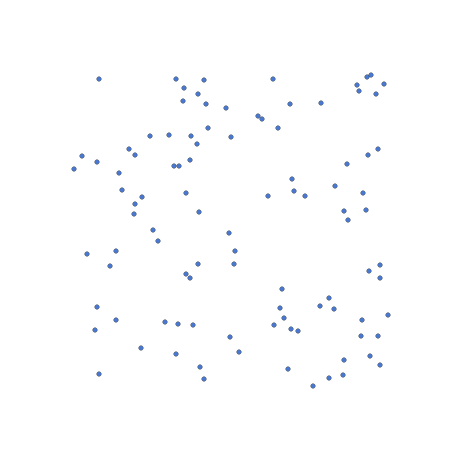

In [46]:
plot_sample(np.random.uniform(0, 10, size=1000), np.random.uniform(0, 10, size=1000))

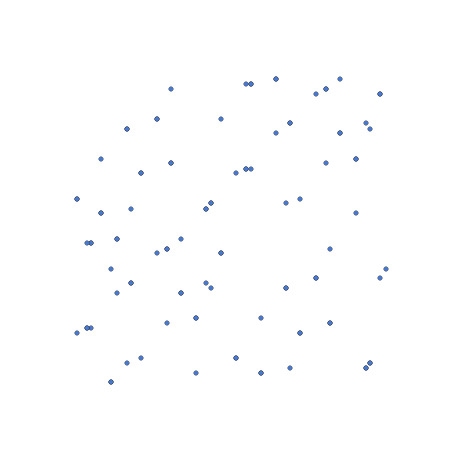

In [47]:
param_values = saltelli_sample.sample(example_problem, 1000)
plot_sample(param_values[:, 0], param_values[:, 1])

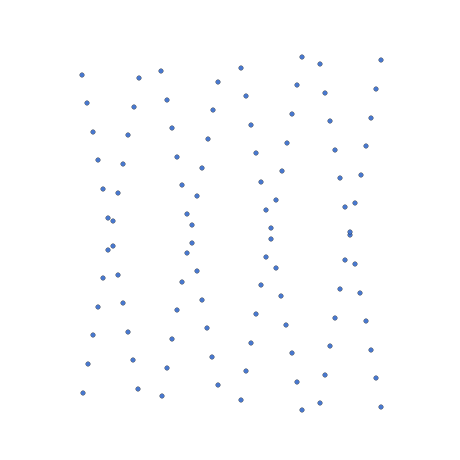

In [48]:
param_values = fast_sampler.sample(example_problem, 1000)
plot_sample(param_values[:, 0], param_values[:, 1])

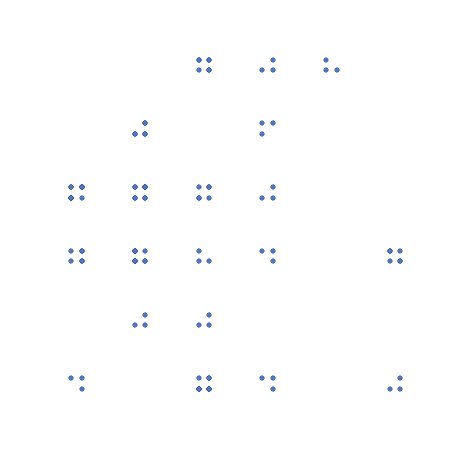

In [28]:
param_values = morris_sample.sample(example_problem, 60, 6, 1/6)
plot_sample(param_values[:, 0], param_values[:, 1])

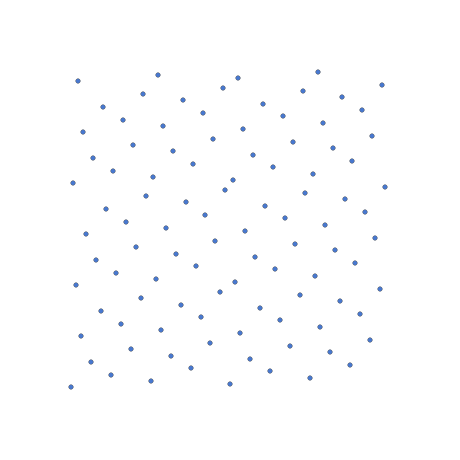

In [51]:
def hammersley(n):
    """Yields n Hammersley points on the unit square in the xy plane.

    From http://www.math.uiuc.edu/~gfrancis/illimath/windows/aszgard_mini/pylibs/cgkit/hammersley.py
    
    This function yields a sequence of n tuples (x,y) which
    represent a point on the unit square. The sequence of points for
    a particular n is always the same.  When n changes an entirely new
    sequence will be generated.
    
    This function uses a base of 2.
    """
    for k in range(n):
        u = 0
        p=0.5
        kk = k
        while kk>0:
            if kk & 1:
                u += p
            p *= 0.5
            kk >>= 1
        v = (k+0.5)/n
        yield (u, v)
        
hammersley_iterator = hammersley(1000)
hammersley_values = np.array([next(hammersley_iterator) for _ in range(1000)])
plot_sample(hammersley_values[:, 0], hammersley_values[:, 1])

# Analysis

## Morris method of elementary effects

In [43]:
morris_values = morris_sample.sample(problem, 2, num_levels=4, grid_jump=2)
morris_results = np.zeros(morris_values.shape[0])

for row in range(morris_values.shape[0]):
    morris_results[row] = objective_function(morris_values[row, :])

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 34.777 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 32.029 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 31.934 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 32.332 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 31.925 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 31.622 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 32.017 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 32.056 sec


In [47]:
morris_analyze.analyze(
    problem, 
    morris_values, 
    morris_results,
    print_to_console=True,
    grid_jump=2,
    num_levels=4
)

Parameter Mu Sigma Mu_Star Mu_Star_Conf
charge rate -75.099992 65.351399 75.099992 63.364872
battery capacity -5.015735 4.372564 5.015735 4.152109
energy consumption 39623.433616 76.984437 39623.433616 75.231915


{'mu': array([ -7.50999920e+01,  -5.01573538e+00,   3.96234336e+04]),
 'mu_star': array([  7.50999920e+01,   5.01573538e+00,   3.96234336e+04]),
 'mu_star_conf': [63.364872166356314, 4.152109196125445, 75.231915167509598],
 'names': ['charge rate', 'battery capacity', 'energy consumption'],
 'sigma': array([ 65.35139858,   4.37256388,  76.98443734])}

## Sobol sequence

In [50]:
sobol_values = saltelli_sample.sample(problem, 1)
sobol_results = np.zeros(sobol_values.shape[0])

for row in range(sobol_values.shape[0]):
    sobol_results[row] = objective_function(sobol_values[row, :])

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 35.337 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 32.676 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 33.141 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 32.795 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 32.070 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 31.851 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 32.772 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 35.251 sec


In [53]:
sobol_analyze.analyze(
    problem, 
    sobol_results,
    print_to_console=True,
)

Parameter S1 S1_conf ST ST_conf
charge rate -0.030786 0.000000 0.000003 0.000000
battery capacity -0.007104 0.000000 0.000000 0.000000
energy consumption 24.036327 0.000000 2.016670 0.000000

Parameter_1 Parameter_2 S2 S2_conf
charge rate battery capacity 0.105155 0.000000
charge rate energy consumption 0.120143 0.000000
battery capacity energy consumption 0.018379 0.000000


{'S1': array([ -3.07863712e-02,  -7.10410046e-03,   2.40363272e+01]),
 'S1_conf': array([  2.05027445e-17,   0.00000000e+00,   6.99827013e-15]),
 'S2': array([[        nan,  0.10515483,  0.12014306],
        [        nan,         nan,  0.01837918],
        [        nan,         nan,         nan]]),
 'S2_conf': array([[             nan,   8.20109781e-17,   0.00000000e+00],
        [             nan,              nan,   0.00000000e+00],
        [             nan,              nan,              nan]]),
 'ST': array([  3.30838132e-06,   1.76163831e-07,   2.01666968e+00]),
 'ST_conf': array([  8.34258810e-22,   0.00000000e+00,   1.74956753e-15])}